# Simple Benchmark on $loss(x) = \|I - x^T x\|^2$ with and without `adaptive=True`

## Prepare environment

### Install required packages


In [1]:
# Uninstall optax and reinstall just to be sure we're using the latest version
!pip uninstall -q optax -y && pip install -q git+https://github.com/leloykun/optax.git@fc--add-muon
# Install plotting libraries
!pip install -q matplotlib seaborn

You can comment out the cell above after running it at least once.

### Import required packages

In [2]:
from functools import partial
from typing import Union, Tuple

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import seaborn as sns
from optax.contrib import muon

## Benchmark

### Utils

In [3]:
def loss(x: jnp.ndarray, n: int):
    return jnp.linalg.norm(jnp.eye(n) - x.T @ x)**2

loss_and_grad_fn = jax.jit(jax.value_and_grad(loss), static_argnames=("n",))

In [4]:
@partial(jax.jit, static_argnames=("n", "num_iterations", "learning_rate", "newton_schulz_coeffs", "newton_schulz_steps", "beta", "adaptive"))
def train(
    x: jnp.ndarray,
    n: int = 2,
    num_iterations: int = 100,
    learning_rate: float = 0.001,
    newton_schulz_coeffs: Union[
      Tuple[float, float, float],
      Tuple[Tuple[float, float, float], ...],
    ] = (3.4445, -4.7750, 2.0315),
    newton_schulz_steps: int = 5,
    beta: float = 0.95,
    adaptive: bool = False,
):
    optimizer = optax.chain(
        muon(
            learning_rate=learning_rate,
            newton_schulz_coeffs=newton_schulz_coeffs,
            newton_schulz_steps=newton_schulz_steps,
            beta=beta,
            adaptive=adaptive,
        )
    )
    opt_state = optimizer.init(x)

    def body_fn(values: tuple[jnp.ndarray, optax.OptState], _):
        x, opt_state = values
        loss, grad = loss_and_grad_fn(x, n)
        updates, opt_state = optimizer.update(grad, opt_state)
        new_x = optax.apply_updates(x, updates)
        return (new_x, opt_state), loss

    _, losses = jax.lax.scan(body_fn, (x, opt_state), length=num_iterations)

    return losses

### Init data

In [5]:
key = jax.random.PRNGKey(0)

N = 2
X = jax.random.uniform(key, shape=(N, N), dtype=jnp.float64)
X.shape

/tmp/ipykernel_15598/2843765696.py:4: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  X = jax.random.uniform(key, shape=(N, N), dtype=jnp.float64)


(2, 2)

### Benchmark body

In [6]:
def benchmark_muon_variants(
    num_iterations: int=100,
    learning_rate: float=0.1,
    beta: float=0.0,
    savefile: str="images/muon_variants.png",
):
    all_losses = []
    for optimize_coeffs in [False, True]:
        for adaptive in [False, True]:
            losses = train(
                X,
                n=N,
                num_iterations=num_iterations,
                learning_rate=learning_rate,
                newton_schulz_coeffs=(
                    (3.4445, -4.7750, 2.0315)
                    if not optimize_coeffs
                    else (
                        (2.9145, -4.3663, 2.4515),
                        (2.9131, -4.3582, 2.4446),
                        (2.9030, -4.3145, 2.4106),
                        (2.8317, -4.0251, 2.1928),
                        (2.8392, -3.3535, 1.5149),
                    )
                ),
                newton_schulz_steps=5,
                beta=beta,
                adaptive=adaptive,
            )
            all_losses.append(losses)

    plt.figure(figsize=(8, 6))
    sns.set_theme(font="monospace")
    for losses, optimized, adaptive in zip(all_losses, [False, False, True, True], [False, True, False, True]):
        sns.lineplot(
            losses,
            label=f"Muon{'; adaptive' if adaptive else '          '}{'; optimized coeffs' if optimized else ''}",
            linestyle="--" if optimized else "-",
        )
    plt.title(f"Muon Variants (beta={beta:.3f}, lr={learning_rate})")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

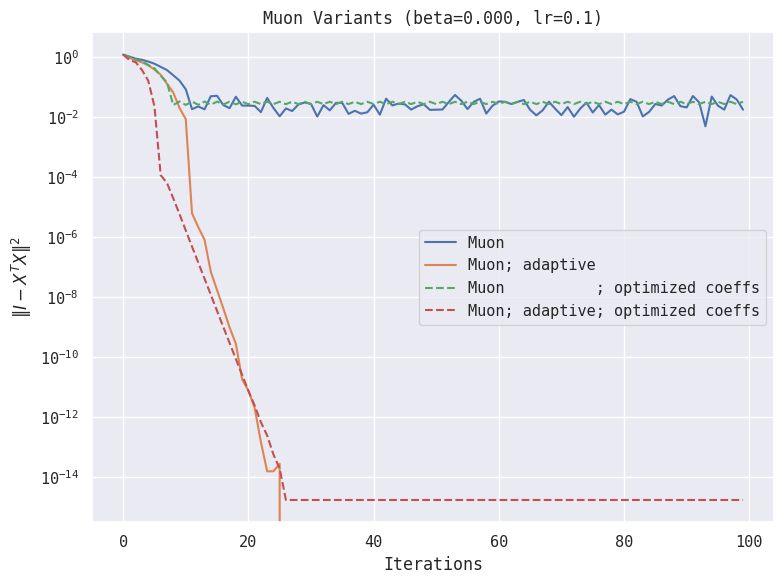

In [7]:
benchmark_muon_variants(
    num_iterations=100,
    learning_rate=0.1,
    beta=0.0,
)

In [8]:
def benchmark_muon_by_momentum_decay(
    adaptive: bool,
    learning_rate: float=0.1,
    num_iterations: int=100,
    optimize_coeffs: bool=False,
    savefile: str="images/adaptive_muon_by_momentum_decay.png",
):
    betas = jnp.linspace(0, 0.999, 10).tolist()
    betas.insert(-1, 0.95)
    all_losses = []

    for beta in betas:
        losses = train(
            X,
            n=N,
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            newton_schulz_coeffs=(
                (3.4445, -4.7750, 2.0315)
                if not optimize_coeffs
                else (
                    (2.9145, -4.3663, 2.4515),
                    (2.9131, -4.3582, 2.4446),
                    (2.9030, -4.3145, 2.4106),
                    (2.8317, -4.0251, 2.1928),
                    (2.8392, -3.3535, 1.5149),
                )
            ),
            newton_schulz_steps=5,
            beta=beta,
            adaptive=adaptive,
        )
        all_losses.append(losses)

    plt.figure(figsize=(8, 6))
    sns.set_theme(font="monospace", palette=sns.color_palette("mako_r", len(betas)))
    for losses, beta in zip(all_losses, betas):
        sns.lineplot(losses, label=f"$\\beta$={beta:.3f}{'**' if beta == 0.95 else ''}")
    plt.title(f"{'Adaptive ' if adaptive else ''}Muon: Limitation of Momentum (lr={learning_rate})")
    plt.xlabel("Iterations")
    plt.ylabel("$\|I - X^TX\|^2$")
    plt.yscale("log")
    plt.legend(title=f"$\\beta$ Values", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(savefile)
    plt.show()

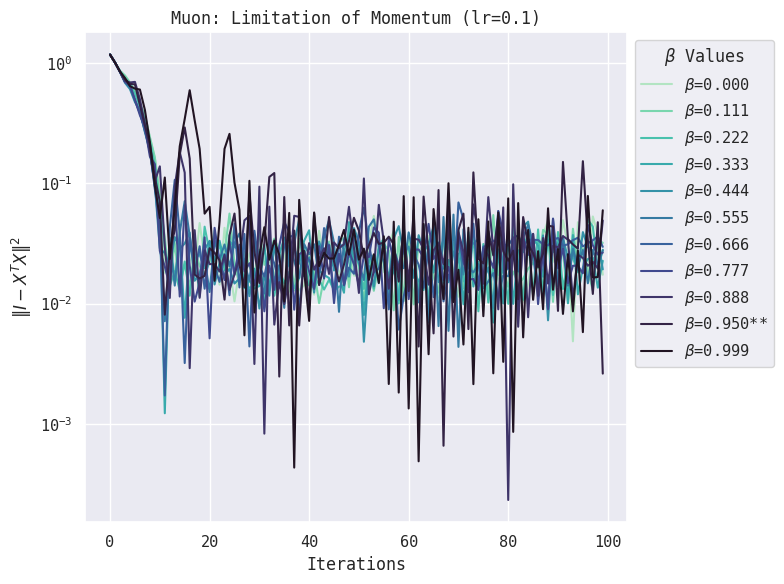

In [9]:
benchmark_muon_by_momentum_decay(
    adaptive=False,
    optimize_coeffs=False,
    savefile="images/muon_by_momentum_decay_optimized_coeffs.png",
)

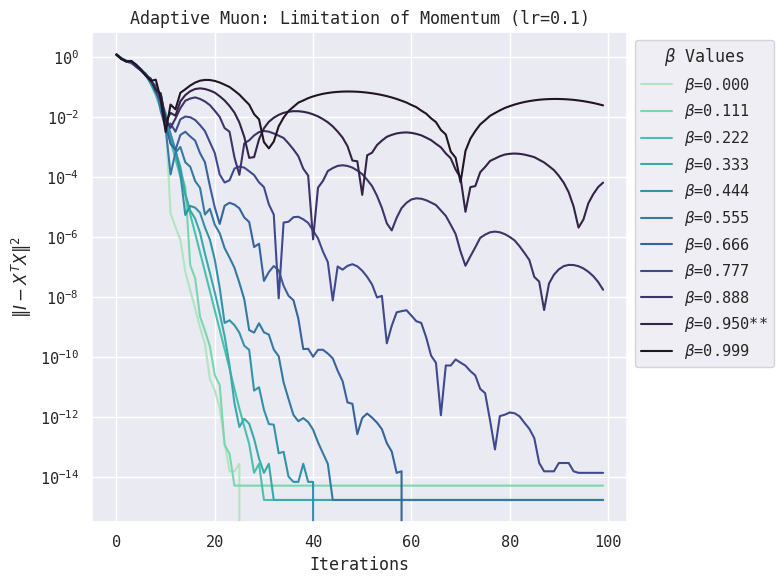

In [10]:
benchmark_muon_by_momentum_decay(
    adaptive=True,
    optimize_coeffs=False,
)

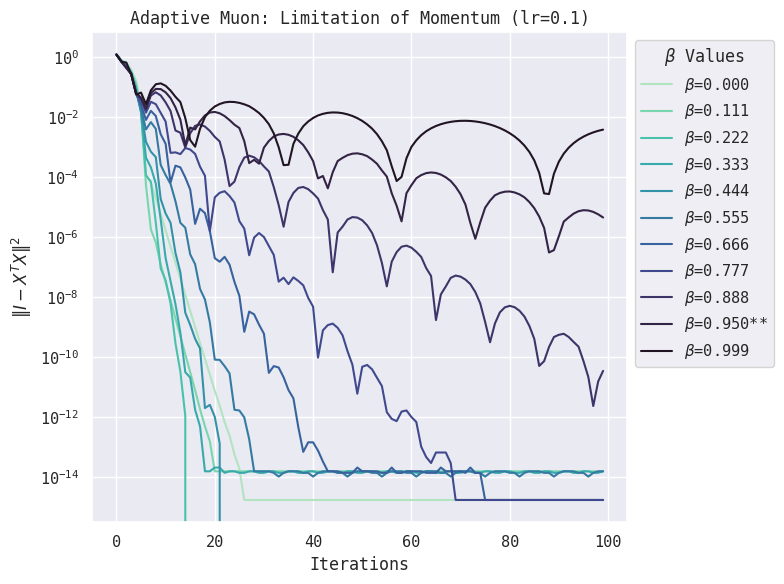

In [11]:
benchmark_muon_by_momentum_decay(
    adaptive=True,
    optimize_coeffs=True,
    savefile="images/adaptive_muon_by_momentum_decay_optimized_coeffs_opt.png",
)